In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.integrate import solve_ivp

In [2]:
def Kder_complex(z,Delta,Omega,K,F): #Returns zdot
    return ((K*z +F) - (z**2)*np.conj(K*z+F))/2 - (Delta + Omega*1j)*z

def Kder_vector(z,Delta,Omega,K,F): #z is treated as a 2D vector in R^2
    x = z[0]
    y = z[1]
    zdot = Kder_complex(x+y*1j,Delta,Omega,K,F)
    xdot = np.real(zdot)
    ydot = np.imag(zdot)
    return [xdot,ydot]

def Kder_integration(t,z,Delta,Omega,K,F): #z is treated as a 2D vector in R^2
    x = z[0]
    y = z[1]
    zdot = Kder_complex(x+y*1j,Delta,Omega,K,F)
    xdot = np.real(zdot)
    ydot = np.imag(zdot)
    return [xdot,ydot]

In [3]:
def getIC(lag,Delta,Omega,K,F):
    solstb = opt.fsolve(Kder_vector,[1,-1],(Delta,Omega,K,F))
    solstb_complex = solstb[0]+1j*solstb[1]
    IC = solstb_complex*np.exp(-1j*lag*np.pi/12)
    return [IC.real,IC.imag,solstb[0],solstb[1]]

In [4]:
t_start_0 = 0
t_end_0 = 1000 #hours
t_step_0 = 1 #hours
Delta = 3.8e-3
Omega = 1.4*Delta
K = 4.5*Delta
F = 3.5*Delta

In [5]:
#This is for the phase plane
def integrate(t_start,t_end,t_step,lag,Delta = Delta,Omega = Omega,K = K,F = F):#Put correct values
    ICx,ICy,solstbx,solstby = getIC(lag,Delta,Omega,K,F)
    IC = [ICx,ICy]
    def recovery(t,z,Delta,Omega,K,F):
        x = z[0]
        y = z[1]
        return (x-solstbx)**2 + (y-solstby)**2 - 0.0001
    recovery.terminal = True
    recovery.direction = -1 #only counts positive to negative crossing
    solution = solve_ivp(Kder_integration,(t_start,t_end),IC,t_eval = np.linspace(t_start,t_end,int((t_end - t_start)/t_step)),events=recovery,args=(Delta,Omega,K,F))
    return solution

In [6]:
myrangex = np.linspace(-1,1,40)
myrangey = np.linspace(-1,1,40)
x,y = np.meshgrid(myrangex,myrangey)
z = x + 1j*y
zdot = Kder_complex(z,Delta = Delta,Omega = Omega,K = K,F = F)#Put correct values here
u = np.real(zdot)/np.abs(zdot)
v = np.imag(zdot)/np.abs(zdot)

In [7]:
solstb = opt.fsolve(Kder_vector,[1,-1],(Delta,Omega,K,F))
solunstb = opt.fsolve(Kder_vector,[0,0],(Delta,Omega,K,F))
solsad = opt.fsolve(Kder_vector,[-1,0],(Delta,Omega,K,F))

F:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


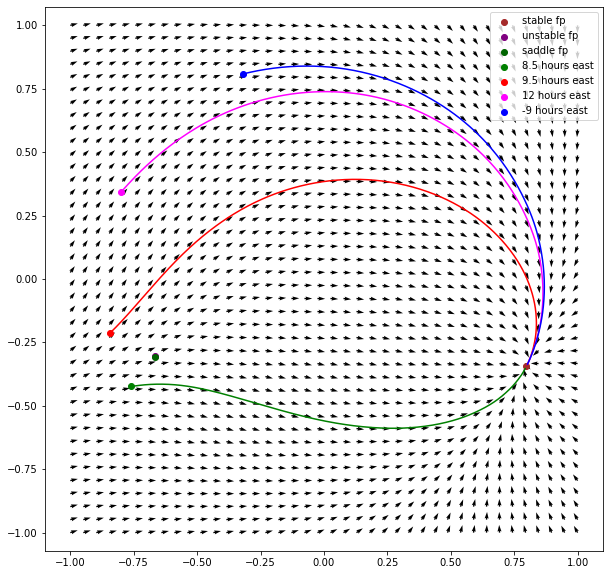

In [8]:
plt.quiver(x,y,u,v)
plt.scatter(solstb[0],solstb[1],label='stable fp',c = 'brown')
plt.scatter(solunstb[0],solunstb[1],label='unstable fp',c='purple')
plt.scatter(solsad[0],solsad[1],label='saddle fp',c='darkgreen')
for index in range(4):
    lags = [8.5,9.5,12,-9]
    colours = ['green','red','magenta','blue']
    lagval = lags[index]
    s = integrate(0,1000,1,lagval)
    ICx,ICy,_,_ = getIC(lagval,Delta = Delta,Omega = Omega,K = K,F = F)#Put correct values here
    plt.scatter(ICx,ICy,c=colours[index],label = str(lags[index])+' hours east')
    plt.plot(s.y[0],s.y[1],c=colours[index])
plt.axis('equal')
plt.gcf().set_size_inches(10,10)
plt.legend()
plt.show()

In [9]:
#This is for the recovery time comparisions
def integrate_recovery_time_comparision(t_start,t_end,t_step,lag,Delta = Delta,Omega = Omega,K = K,F = F):#Put correct values
    ICx,ICy,solstbx,solstby = getIC(lag,Delta,Omega,K,F)
    IC = [ICx,ICy]
    def recovery(t,z,Delta,Omega,K,F):
        x = z[0]
        y = z[1]
        return (x-solstbx)**2 + (y-solstby)**2 - 0.04
    recovery.terminal = True
    recovery.direction = -1 #only counts positive to negative crossing
    solution = solve_ivp(Kder_integration,(t_start,t_end),IC,t_eval = np.linspace(t_start,t_end,int((t_end - t_start)/t_step)),events=recovery,args=(Delta,Omega,K,F))
    return solution

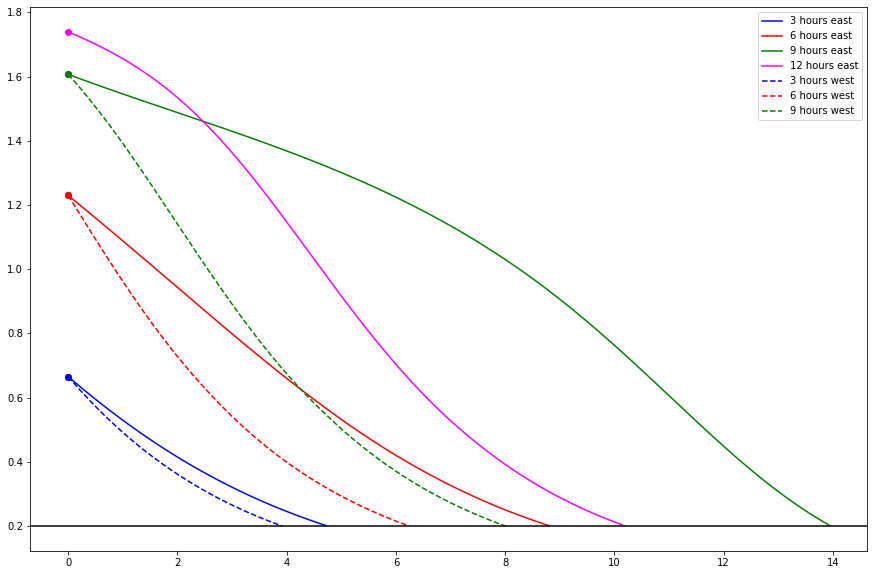

In [10]:
for index in range(4):
    lags = [3,6,9,12]
    colours = ['blue','red','green','magenta','blue','red','green']
    lagval = lags[index]
    s = integrate_recovery_time_comparision(0,1000,1,lagval)
    ICx,ICy,solstbx,solstby = getIC(lagval,Delta = Delta,Omega = Omega,K = K,F = F)#Put correct values here
    plt.scatter(0,((ICx-solstbx)**2 + (ICy-solstby)**2)**0.5,c=colours[index])
    plt.plot(s.t/24,((s.y[0]-solstbx)**2 + (s.y[1]-solstby)**2)**0.5,c=colours[index],label = str(lags[index])+' hours east')
for index in range(3):
    lags = [-3,-6,-9]
    colours = ['blue','red','green']
    lagval = lags[index]
    s = integrate_recovery_time_comparision(0,1000,1,lagval)
    ICx,ICy,solstbx,solstby = getIC(lagval,Delta = Delta,Omega = Omega,K = K,F = F)#Put correct values here
    plt.scatter(0,((ICx-solstbx)**2 + (ICy-solstby)**2)**0.5,c=colours[index])
    plt.plot(s.t/24,((s.y[0]-solstbx)**2 + (s.y[1]-solstby)**2)**0.5,c=colours[index],linestyle='dashed',label = str(abs(lags[index]))+' hours west')
plt.gcf().set_size_inches(15,10)
plt.axhline(y=0.2, color='black')
plt.axis()
plt.legend()
plt.show()

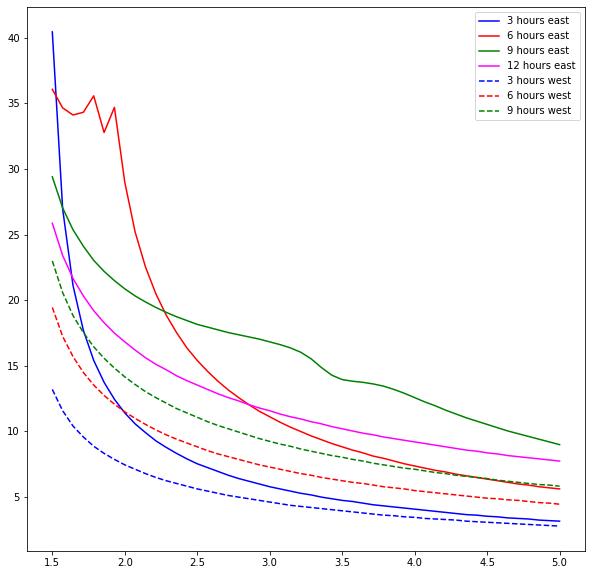

In [11]:
#Versus F/delta
for index in range(4):
    lags = [3,6,9,12]
    colours = ['blue','red','green','magenta']
    lagval = lags[index]
    
    Fspace = np.linspace(1.5,5,50)
    vals=[]
    for f in Fspace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,F = f*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Fspace,vals,c=colours[index],label=str(lags[index])+" hours east")
for index in range(3):
    lags = [-3,-6,-9]
    colours = ['blue','red','green']
    lagval = lags[index]
    
    Fspace = np.linspace(1.5,5,50)
    vals=[]
    for f in Fspace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,F = f*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Fspace,vals,c=colours[index],linestyle='dashed',label = str(abs(lags[index]))+' hours west')
plt.gcf().set_size_inches(10,10)
plt.axis()
plt.legend()
plt.show()

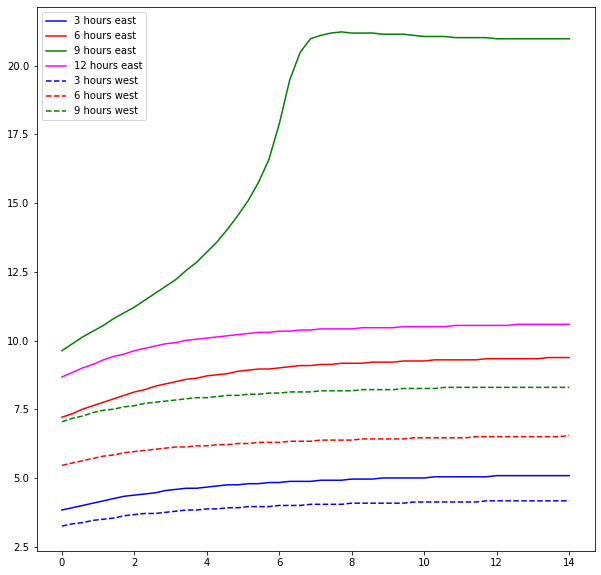

In [12]:
#Versus K/delta
for index in range(4):
    lags = [3,6,9,12]
    colours = ['blue','red','green','magenta']
    lagval = lags[index]
    
    Kspace = np.linspace(0,14,50)
    vals=[]
    for k in Kspace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,K = k*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Kspace,vals,c=colours[index],label=str(lags[index])+" hours east")
for index in range(3):
    lags = [-3,-6,-9]
    colours = ['blue','red','green']
    lagval = lags[index]
    
    Kspace = np.linspace(0,14,50)
    vals=[]
    for k in Kspace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,K = k*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Kspace,vals,c=colours[index],linestyle='dashed',label = str(abs(lags[index]))+' hours west')
plt.gcf().set_size_inches(10,10)
plt.axis()
plt.legend()
plt.show()

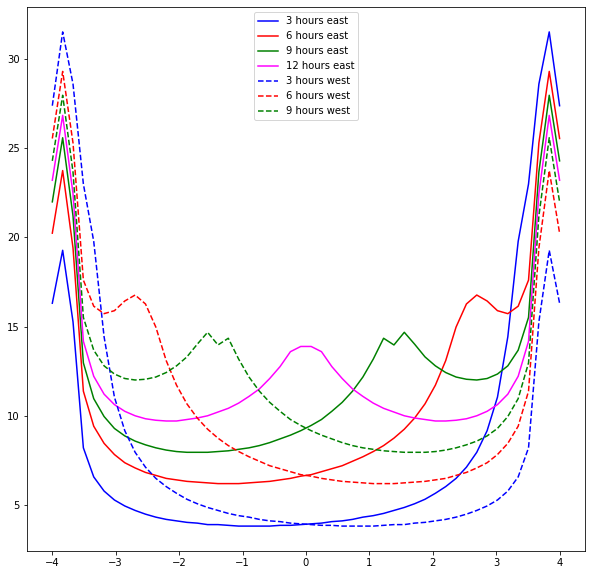

In [13]:
#Versus omega/delta
for index in range(4):
    lags = [3,6,9,12]
    colours = ['blue','red','green','magenta']
    lagval = lags[index]
    
    Ospace = np.linspace(-4,4,50)
    vals=[]
    for o in Ospace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,Omega = o*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Ospace,vals,c=colours[index],label=str(lags[index])+" hours east")
for index in range(3):
    lags = [-3,-6,-9]
    colours = ['blue','red','green']
    lagval = lags[index]
    
    Ospace = np.linspace(-4,4,50)
    vals=[]
    for o in Ospace:
        s = integrate_recovery_time_comparision(0,1000,1,lagval,Omega = o*Delta)
        vals.append(max(s.t)/24)
    plt.plot(Ospace,vals,c=colours[index],linestyle='dashed',label = str(abs(lags[index]))+' hours west')
plt.gcf().set_size_inches(10,10)
plt.axis()
plt.legend()
plt.show()